In [5]:
data_path = "new_sequences20.dat"

In [6]:
import math
import time
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import matrix_power
from sympy.geometry import Point, Circle
from numpy import pi

In [7]:
tolerance = 1e-6
epsilon = .1

In [8]:
def isOdd(sequence):
    return len(sequence) % 2

In [9]:
def isEven(sequence):
    return not isOdd(sequence)

In [10]:
def genLen(generator):
    return sum(1 for _ in generator)

In [11]:
def cfToMatrix(sequence):
    matrix = np.eye(2, dtype=np.int64)
    for x in sequence:
        matrix = np.matmul(matrix, [[x, 1], [1, 0]])
    return matrix

In [12]:
def npCfReduce(cf): #works on fully periodic continued fractions
    mat = cfToMat(cf)
    return (mat[0,0]-mat[1,1] + math.sqrt(mat[0,0]**2+mat[1,1]**2+2*mat[1,0]*mat[0,1]-2))/(2*mat[1,0])

In [13]:
def cfMatrixTrace(sequence):
    return np.trace(cfToMatrix(sequence))

In [14]:
def asMatrix(sequence):
    return cfToMatrix(sequence + sequence if isOdd(sequence) else sequence)

In [15]:
def matrixTrace(sequence):
    return np.trace(asMatrix(sequence))

In [16]:
def rotl(x, k):
    return x[k:] + x[:k]

In [17]:
def minRot(x, step=1):
    return min(rotl(x, k) for k in range(0, len(x), step))

In [18]:
def minRot2(x):
    return minRot(x, step=2)

In [19]:
def traceToLength(t):
    return 2 * np.arccosh(t / 2)

In [20]:
def lengthToTrace(l):
    return 2 * np.cosh(l / 2)

In [21]:
def actualSequencesGen(data, length):
    min_trace = int(lengthToTrace(length)) + 1
    max_trace = int(lengthToTrace(length + 1)) + 1
    for x in data:
        trace = matrixTrace(x)
        if trace < min_trace or trace >= max_trace:
            x *= int((length + 1) / traceToLength(trace))
        if isOdd(x):
            # Expand condensed form, and then symmetrize by time reversal
            yield x + x
        else:
            # Symmetrize by both R-L flip and time reversal, and add all four
            yield x
            yield rotl(x, 1)

In [22]:
def actualSequences(data, length):
    return list(actualSequencesGen(data, length))

In [23]:
def guysForTraceGen(data, trace):
    length = int(traceToLength(trace))
    sequences = actualSequencesGen(data.get(length), length)
    matched = (x for x in sequences if cfMatrixTrace(x) == trace)
    yield from reduceAndRemoveDuplicatesGen(matched)

In [24]:
def guysForTrace(data, trace):
    return list(guysForTraceGen(data, trace))

In [25]:
def geosInTraceRangeGen(data, tmin, tmax):
    for i in range(tmin, tmax + 1):
        yield from guysForTraceGen(data, i)

In [26]:
def geosInTraceRange(data, tmin, tmax):
    return list(geosInTraceRangeGen(data, tmin, tmax))

In [27]:
def pantsInTraceRange(data, tmin, tmax):
    return getPants(geosInTraceRangeGen(data, tmin, tmax))

def pantsInTraceRange2(data, tmin, tmax):
    return getPants2(geosInTraceRangeGen(data, tmin, tmax))

In [28]:
def pantsInTraceRangeDict(data, tmin, tmax):
    return getPantsDict(geosInTraceRangeGen(data, tmin, tmax))

In [29]:
def reduceAndRemoveDuplicatesGen(sequences):
    for x in {tuple(minRot2(s)) for s in sequences}:
        if minRot2(x[::-1]) != x:
            yield list(x)

In [30]:
def reduceAndRemoveDuplicates(sequences):
    return list(reduceAndRemoveDuplicatesGen(sequences))

In [31]:
def cfListToDicts(cfs):
    forward, reverse = {}, {}
    for cf in cfs:
        for left, right in split(cf):
            if left in forward:
                forward[left].add(right)
            else:
                forward[left] = {right}
            if right in reverse:
                reverse[right].add(left)
            else:
                reverse[right] = {left}
    return forward, reverse

In [32]:
def permutationsOfGen(sequence):
    for n in range(0, len(sequence), 1 if isOdd(sequence) else 2):
        yield rotl(sequence, n)

In [33]:
def permutationsOf(sequence):
    return list(permutationsOfGen(sequence))

In [34]:
def minPermutations(sequence):
    return min(permutationsOfGen(sequence))

In [35]:
def inv(lr_sequence):
    return tuple((np.array(lr_sequence[::-1]) - 1) ** 2)

In [36]:
def splitGen(continued_fraction):
    converted = contFracToLR(continued_fraction)
    n = len(converted)
    for i, j in pairsGen(converted):
        rotated = rotl(converted, i)
        yield (tuple(rotated[1:(j - i) % n]),
               tuple(inv(rotated[(j - i) % n + 1:])))

In [37]:
def split(continued_fraction):
    return list(splitGen(continued_fraction))

In [38]:
def contFracToLRGen(continued_fraction):
    if isOdd(continued_fraction):
        continued_fraction += continued_fraction
    for i in range(len(continued_fraction)):
        for j in range(continued_fraction[i]):
            yield i % 2

In [39]:
def contFracToLR(continued_fraction):
    return list(contFracToLRGen(continued_fraction))

In [40]:
def indicesGen(lr_sequence):
    for i in range(len(lr_sequence)):
        if lr_sequence[i] == 1:
            yield i

In [41]:
def indices(lr_sequence):
    return list(indicesGen(lr_sequence))

In [42]:
def pairsGen(lr_sequence):
    sequence_indices = indices(lr_sequence)
    for i in sequence_indices:
        for j in sequence_indices:
            if i != j:
                yield (i, j)

In [43]:
def pairs(lr_sequence):
    return list(pairsGen(lr_sequence))

In [44]:
def recover(ls):
    output = []
    i = 0
    while i < len(ls):
        counter = 1
        while (i < len(ls) - 1 and ls[i] == ls[i + 1]):
            i += 1
            counter += 1
        i += 1
        output.append(counter)
    if isOdd(output):    #this is the line where we lump things
        output[-1] += output[0]
        output = output[1:]
    return output

def recover2(ls):
    output = []
    i = 0
    while i < len(ls):
        counter = 1
        while (i < len(ls) - 1 and ls[i] == ls[i + 1]):
            i += 1
            counter += 1
        i += 1
        output.append(counter)
    if isOdd(output):  
        output = [0]+output
    return output

In [45]:
def pairToFrac(s1, s2):
    return minPermutations(recover(list(s1) + [1] + list(inv(s2)) + [1]))

def pairToFrac2(s1,s2):
    return recover2(list(s1) + [1] + list(inv(s2)) + [1])

In [46]:
def getPants(cf_list): #output here is set of triples of theta sequences
    forward, reverse = cfListToDicts(cf_list)
    pants = set()
    for s0 in forward:
        for s1 in forward[s0]:
            if s1 in forward and s0 in reverse:
                for s2 in forward[s1].intersection(reverse[s0]):
                    y0 = pairToFrac(s0, s1)
                    y1 = pairToFrac(s1, s2)
                    y2 = pairToFrac(s2, s0)
                    s0i, s1i,s2i = inv(s0), inv(s1), inv(s2)
                    if not (y0 == y1 or y1 == y2 or y0 == y2):
                        if (s1,s2,s0) not in pants and (s2,s0,s1) not in pants and (s2i,s1i,s0i) not in pants and (s1i,s0i,s2i) not in pants and (s0i,s2i,s1i) not in pants:
                            pants.add((s0, s1, s2))
    return pants

def getPants2(cf_list): #output here is list of triples of geos
    forward, reverse = cfListToDicts(cf_list)
    pants = set()
    for s0 in forward:
        for s1 in forward[s0]:
            if s1 in forward and s0 in reverse:
                for s2 in forward[s1].intersection(reverse[s0]):
                    y0 = pairToFrac(s0, s1)
                    y1 = pairToFrac(s1, s2)
                    y2 = pairToFrac(s2, s0)
                    if not (y0 == y1 or y1 == y2 or y0 == y2):
                        pants.add((y0, y1, y2))
    return pants

In [47]:
def getPantsDict(cf_list):
    forward, reverse = cfListToDicts(cf_list)
    pantsDict = {}
    for s0 in forward:
        for s1 in forward[s0]:
            if s1 in forward and s0 in reverse:
                for s2 in forward[s1].intersection(reverse[s0]):
                    y0 = tuple(pairToFrac(s0, s1))
                    y1 = tuple(pairToFrac(s1, s2))
                    y2 = tuple(pairToFrac(s2, s0))
                    s0i, s1i,s2i = inv(s0), inv(s1), inv(s2)
                    if not (y0 == y1 or y1 == y2 or y0 == y2):
                        if y0 in pantsDict and (s1,s2,s0) not in pantsDict[y0] and (s2,s0,s1) not in pantsDict[y0] and (s2i,s1i,s0i) not in pantsDict[y0] and (s1i,s0i,s2i) not in pantsDict[y0] and (s0i,s2i,s1i) not in pantsDict[y0]:
                            pantsDict[y0].add((s0,s1,s2))
                        else:
                            pantsDict[y0] = {(s0,s1,s2)}
                        if y1 in pantsDict and (s1,s2,s0) not in pantsDict[y0] and (s2,s0,s1) not in pantsDict[y0] and (s2i,s1i,s0i) not in pantsDict[y0] and (s1i,s0i,s2i) not in pantsDict[y0] and (s0i,s2i,s1i) not in pantsDict[y0]:
                            pantsDict[y1].add((s0,s1,s2))
                        else:
                            pantsDict[y1] = {(s0,s1,s2)}
                        if y2 in pantsDict and (s1,s2,s0) not in pantsDict[y0] and (s2,s0,s1) not in pantsDict[y0] and (s2i,s1i,s0i) not in pantsDict[y0] and (s1i,s0i,s2i) not in pantsDict[y0] and (s0i,s2i,s1i) not in pantsDict[y0]:
                            pantsDict[y2].add((s0,s1,s2))
                        else:
                            pantsDict[y2] = {(s0,s1,s2)}
    return pantsDict

In [48]:
def pantsInTraceRangeWithCuff(data, tmin, tmax, cutting_sequence):
    pants_with_cuff = []
    for pants in pantsInTraceRange(data, tmin, tmax):
        if cutting_sequence in pants:
            pants_with_cuff.append(pants)
    return pants_with_cuff

In [49]:
def pantsInTraceRangeWithCuffGen(data, tmin, tmax, cutting_sequence):
    for pants in pantsInTraceRange(data, tmin, tmax):
        if cutting_sequence in pants:
            yield pants

In [50]:
def boundaryCountForOrientedCuffs(data, tmin, tmax, cutting_sequence):
    cutting_sequence_reverse = cutting_sequence[::-1]
    positive = pantsInTraceRangeWithCuffGen(data, tmin, tmax, minPermutations(cutting_sequence))
    negative = pantsInTraceRangeWithCuffGen(data, tmin, tmax, minPermutations(cutting_sequence_reverse))
    return genLen(positive) - genLen(negative)

In [51]:
def cfToMat(cf):
    mat = np.identity(2)
    length = 0
    for x in cf:
        mat = np.matmul(mat, [[x, 1], [1, 0]])
        length += 1
    if length % 2:
        mat = np.matmul(mat, mat)
    return np.array(mat).astype(int)

In [52]:
def halfLength(cf):
    return math.acosh(np.trace(cfToMat(cf))/2)

In [53]:
def pantsToGeodesics(pants_list):
    positives = []
    for pants in pants_list:
        geos = [pairToFrac(pants[0], pants[1]), pairToFrac(pants[1], pants[2]), pairToFrac(pants[2], pants[0])]
        for geodesic in geos:
            min_geo = minPermutations(geodesic)
            min_inv_geo = minPermutations(min_geo[::-1])
            if not (min_geo in positives or min_inv_geo in positives):
                positives.append(min_geo)
    return positives

In [54]:
def geosToEyesGen(geodesics):
    for geodesic in geodesics:
        for i in range(0, len(geodesic), 2):
            rotated = rotl(list(geodesic), i)[1:]
            rotated[0] -= 1
            rotated[-1] -= 1
            yield (geodesic, tuple(rotated))

In [55]:
def geosToEyes(geodesics):
    return list(geosToEyesGen(geodesics))

In [56]:
def cuspInv(cusp):
    inv_cusp = list(cusp[::-1])
    if len(inv_cusp) == 1 and inv_cusp[0] <= 0:
        return tuple(inv_cusp)
    else:
        if inv_cusp[0] == 0:
            inv_cusp = inv_cusp[1:]
        else:
            inv_cusp = [0] + inv_cusp
        if inv_cusp[-1] == 0:
            inv_cusp = inv_cusp[:-1]
        else:
            inv_cusp = inv_cusp + [0]
        return tuple(inv_cusp)

In [57]:
def eyesToCusps(eyes):
    cusps = []
    for eye in eyes:
        eye = eye[1]
        inv_eye = cuspInv(eye)
        if not (eye in cusps or inv_eye in cusps):
            cusps.append(eye)
    return cusps

In [58]:
def pantsAndEyesToMatrix(pants_list, eye_list, pos_geos, pos_cusps):
    geo_indices, cusp_indices = {}, {}
    basis_count = len(pos_geos) + len(pos_cusps)
    
    for i in range(basis_count):
        if i < len(pos_geos):
            geo_indices[pos_geos[i]] = i 
        else:
            cusp_indices[pos_cusps[i - len(pos_geos)]] = i

    columns = []
    for pants in pants_list:
        column = np.zeros(basis_count)
        for geo in pants:
            if geo in geo_indices:
                column[geo_indices[geo]] = 1
            else:
                column[geo_indices[minPermutations(geo[::-1])]] = -1
        columns.append(column)
    
    for eye in eye_list:
        column = np.zeros(basis_count)
        if eye[0] in geo_indices:
            column[geo_indices[eye[0]]] = 1
        else:
            column[geo_indices[minPermutations(eye[0][::-1])]] = -1
        if eye[1] in cusp_indices:
            column[cusp_indices[eye[1]]] = 1
        else:
            column[cusp_indices[cuspInv(eye[1])]] = -1
        columns.append(column)
    
    return np.column_stack(columns)

In [59]:
class LineReader:
    """
    Read a static file with smart line access.

    WARNING: This implementation assumes that the file does not change between
    calls of the `clear` function and never checks for valid file handlers.
    """

    def __init__(self, file_handle=None, parser=lambda e: e):
        """Initialize the LineReader."""
        self.file_handle = file_handle
        self.parser = parser
        self.clear()

    def clear(self):
        """Clear line cache and offset table."""
        self.cache = {}
        self.offsets = []

    def get(self, n):
        """
        Get line as fast as possible, using the line cache and offset table.
        """
        line = self.cache.get(n)
        if line is not None or n < 0:
            return line
        offset_index = len(self.offsets) - 1
        if offset_index >= n:
            self.file_handle.seek(self.offsets[n])
            self.cache[n] = self.parser(self.file_handle.readline()[:-1])
            return self.cache[n]
        if not self.offsets:
            self.offsets.append(0)
            offset_index = 0
        self.file_handle.seek(self.offsets[-1])
        for (index, line) in enumerate(self.file_handle, start=offset_index):
            self.offsets.append(self.offsets[-1] + len(line))
            if index == n:
                self.cache[n] = self.parser(line[:-1])
                return self.cache[n]
        return None

In [60]:
def getOrtho(circ1,circ2):
    r1,x1 = circ1 
    r2,x2 = circ2
    if abs(x1-x2)<tolerance:
        return (np.inf, (x1+x2)/2)
    c1 = x1**2-r1**2
    c2 = x2**2-r2**2
    h = (c1-c2)/(2*(x2-x1))
    x3 = -h
    r3 = math.sqrt(h**2+2*x1*h+c1)
    return (r3, x3)

In [61]:
def toInterval(circ): #we implicitly assume that we can never have trivial intervals of (x,x) = emptyset
    r,x = circ
    if r==np.inf:
        return (x,np.inf)
    elif r==np.NINF:
        return (np.NINF,x)
    else:
        return (x-r, x+r)

In [62]:
def getDist(circ1,circ2):
    circ1,circ2 = getInv(circ1), getInv(circ2)
    t1,u1,v1 = circ1
    t2,u2,v2 = circ2
    a = (t1*u2/2+t2*u1/2-v1*v2)
    return math.acosh(abs(a)+tolerance)

In [63]:
def getInv(circ):
    r,x = circ
    if r == np.inf or r == np.NINF:
        return (2*x,0,1)
    return ((x**2-r**2)/r, 1/r, x/r)

In [64]:
def InvToNormal(circ,N):
    t,u,v = circ
    if abs(u)<tolerance:
        return (np.inf,t/2)
    else:
        r = 1/u
        x = r*v
        return (r,x)

In [65]:
def pIsIn(p,interval): # open intervals
    if interval[0] < interval[1]:
        return interval[0] < p and p < interval[1]
    else:
        return interval[0] < p or p < interval[1]

In [66]:
def intIsIn(int1, int2): # returns whether interval 1 contains interval 2 (i.e. True = "1 contains 2")
    if int1[0] < int1[1] and int2[0] < int2[1]:
        return int1[0] <= int2[0] and int1[1] >= int2[1]
    elif int1[0] > int1[1] and int2[0] < int2[1]:
        return int1[0] <= int2[0] or int2[1] <= int1[1]
    elif int1[0] > int1[1] and int2[0] > int2[1]:
        return int1[0] <= int2[0] and int1[1] >= int2[1]
    else:
        return False

In [67]:
def act(M,x):
    return (M[0,0]*x+M[0,1])/(M[1,0]*x+M[1,1])

In [68]:
def radiusCenterPlotter(circArray,s= 5): #draw circle given an array of radii and centers
    fig, ax = plt.subplots()
    fig.set_size_inches(s, s)
    circles = [circ for circ in circArray if circ[0]!=np.inf and circ[0]!=-np.inf]
    lines = [line for line in circArray if line[0]==np.inf or line[0]==-np.inf]
    minimum = min([circ[1]-abs(circ[0]) for circ in circles]+[l[1] for l in lines])
    maximum = max([circ[1]+abs(circ[0]) for circ in circles]+[l[1] for l in lines])
    ranges = maximum-minimum
    maximum+=ranges/20
    minimum-=ranges/20
    maxY = max([abs(circ[0]) for circ in circles])
    maxY+=maxY/20
    ax.set_xlim(float(minimum),float(maximum))
    ax.set_ylim(0, float(maxY))
    
    for circ in circles:
        plotCirc = plt.Circle((circ[1],0), abs(circ[0]), fill = False)
        if circ[0] > 0:
            plt.plot(circ[1], abs(circ[0]), '>')
        else:
            plt.plot(circ[1], abs(circ[0]), '<')
        ax.add_artist(plotCirc)
    for line in lines:
        plt.vlines(line[1], 0, float(maxY))
        if line[0]> 0:
            plt.plot(line[1],float(maxY/2), '^')
        else:
            plt.plot(line[1],float(maxY/2), 'v')
    ax.set_aspect('equal', adjustable='box')

In [69]:
def circlePoints(circ, N = 100):
    r,x = circ
    x_values,y_values = [],[]
    for i in range(N+1):
        curr_x = x+abs(r)*math.cos(math.pi*i/N)
        curr_y = abs(r)*math.sin(math.pi*i/N)
        x_values.append(curr_x)
        y_values.append(curr_y)
    if r < 0:
        return (x_values,y_values)
    else:
        return (x_values[::-1],y_values[::-1])

In [70]:
def h(point):
    xVals, yVals = point[0][0], point[0][1]
    output = [[],[]]
    for i in range(len(xVals)):
        x,y = xVals[i],yVals[i]
        a = x**2+(y+1)**2
        output[0].append((x**2+y**2-1)/a)
        output[1].append(-2*x/a)
    return output

In [71]:
def add_arrow(line, position=None, direction='right', size=15):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    start_ind = np.argmin(abs(xdata - position))
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle='simple'),
        size=size
    )

In [72]:
def radiusCenterPlotter2(circArray,s=5,n=0): #draw circle given an array of radii and centers
    if n==0:
        n = len(circArray)
    dashed_val = 'solid'
    fig, ax = plt.subplots()
    fig.set_size_inches(s, s)
    circles = [circ for circ in circArray if circ[0]!=np.inf and circ[0]!=-np.inf]
    lines = [line for line in circArray if line[0]==np.inf or line[0]==-np.inf]
    ax.set_xlim(-1,1.01)
    ax.set_ylim(-1.001,1.001)
    points = []
    plotCirc = plt.Circle((0,0), 1, fill = False)
    ax.add_artist(plotCirc)
    plotCirc = plt.Circle((1,0), math.log(s)/100, fill = True, color = 'black', clip_on = False)
    ax.add_artist(plotCirc)
    plotCirc = plt.Circle((0,-1), math.log(s)/100, fill = True, color = 'black', clip_on = False)
    ax.add_artist(plotCirc)
    plotCirc = plt.Circle((-1,0), math.log(s)/100, fill = True, color = 'black', clip_on = False)
    ax.add_artist(plotCirc)
    for circ in circles:
        points += [(circlePoints((circ[0], circ[1])),)]
    for i in range(len(circles)):
        circ = circles[i]
        x_values,y_values = h(points[i])
        if i>(n-1):
            dashed_val = 'dashed'
        line = plt.plot(x_values,y_values, 'black', linewidth = .3, linestyle = dashed_val)[0]    
        pos = len(x_values)//2
        angle = 180*math.atan2((y_values[pos+1]-y_values[pos]),(x_values[pos+1]-x_values[pos]))/math.pi
        plt.plot(x_values[pos],y_values[pos], marker = (3, 0, angle+35), markersize=10, linestyle='None')
   
    for line in lines:
        points = [[(line[1],line[1],line[1]),(5,10,15)]]
        points = h(points)
        p = points
        points = (Point(p[0][0],p[1][0]), Point(p[0][1],p[1][1]), Point(p[0][2],p[1][2]))
        circ = Circle(points[0],points[1],points[2])
        r,center = circ.radius, (circ.center[0].evalf(),circ.center[1].evalf())
        plotCirc = plt.Circle((center[0],center[1]), abs(r), fill = False, linestyle = 'dashed')
        ax.add_artist(plotCirc)
        #if line[0]< 0:
        #    add_arrow(plotCirc,position = x_values[len(x_values)//2], direction = 'right')
        #else:
        #    add_arrow(plotCirc,position = x_values[len(x_values)//2], direction = 'left')
    ax.set_aspect('equal', adjustable='box')
    plt.axis('off')
    ax.annotate(r"$\infty$",(1,0),(1+math.log(s)/50,-math.log(s)/55), size = 15*math.log(s))
    #plt.plot((1,0),color = 'black', marker = "o", markersize=10)
    plt.show()

In [73]:
def pantsInPlane(pants): #y0 is on top, y2 on left, y1 in default position (reduced position +1)
    circles = []
    s0,s1,s2 = pants
    y2 = pairToFrac2(s0,s1)
    y0 = pairToFrac2(s1,s2)
    y1 = pairToFrac2(s2,s0)
    B = lambda x : 1/(1-x)
    
    alpha = npCfReduce(y0)
    alpha_conj = -1/(npCfReduce(y0[::-1]))
    x_min = B(alpha_conj+1)
    x_max = B(alpha+1)
    r = (x_max-x_min)/2
    x = (x_min+x_max)/2
    circles.append((r,x))
    
    alpha = npCfReduce(y1)
    alpha_conj = -1/(npCfReduce(y1[::-1]))
    x_min = (alpha_conj+1)
    x_max = (alpha+1)
    r = (x_max-x_min)/2
    x = (x_min+x_max)/2
    circles.append((r,x))
    
    alpha = npCfReduce(y2)
    alpha_conj = -1/(npCfReduce(y2[::-1]))
    x_min = B(B(alpha_conj+1))
    x_max = B(B(alpha+1))
    r = (x_max-x_min)/2
    x = (x_min+x_max)/2
    circles.append((r,x))
    
    return circles

In [74]:
def pantsPutterInv(pants1, pants2, # pants1 contains y, pants2 contains inv(y)
                   y, s = 5, vis = True): # y is given in minimal form, without any 0's 
    s0,s1,s2 = pants1
    pants1Arr = []
    
    pants1Arr.append(pairToFrac(s1,s2))
    pants1Arr.append(pairToFrac(s2,s0))
    pants1Arr.append(pairToFrac(s0,s1))
    #pair to frac here sends extra R's at the front to the end, so it makes sense to compare to y later.
    
    i = -1
    for l in range(3):
        if pants1Arr[l] == y:
            i = l
    
    pants1_new = [pairToFrac2(s1,s2),pairToFrac2(s2,s0),pairToFrac2(s0,s1)]
    pants1_new = pants1_new[i:] + pants1_new[:i]
    pants1  = pants1[i:] + pants1[:i]
    
    #the above puts the cuff that matches to y into the first slot of the array
    #example: if i = 1, then pants1_new = [gamma1,gamma2,gamma0], and pants1 = [s1,s2,s0]
    
    s0,s1,s2 = pants2
    
    pants2Arr = []
    
    pants2Arr.append(pairToFrac(s1,s2))
    pants2Arr.append(pairToFrac(s2,s0))
    pants2Arr.append(pairToFrac(s0,s1))
    
    for l in range(3):
        if minPermutations(pants2Arr[l][::-1]) == y:
            i = l
    
    pants2_new = [pairToFrac2(s1,s2),pairToFrac2(s2,s0),pairToFrac2(s0,s1)]
    pants2_new = pants2_new[i:] + pants2_new[:i]
    pants2 = pants2[i:] + pants2[:i]
    #the above puts the cuff that matches to the inverse of y into the first slot of the array
    
    gamma_1 = pants1_new[0]
    gamma_2 = pants2_new[0]
    
    #the above are the two geodesics we want to match
    A_1 = np.eye(2)
    A_2 = np.eye(2)
    if gamma_1[0]==0:
        A_1 = np.linalg.inv(np.array([[0,1],[1,-gamma_1[1]]]) @ np.array([[0,1],[1,0]]))
        gamma_1[-1]+=gamma_1[1]
        gamma_1 = gamma_1[2:]
    
    #the above occurs when the start of the geo cutting sequence was an R and we then put a 0 in the cont frac
    #to represent L^0
    #we then store A_1 as the matrix that acts on the continued fraction by concatenating gamma_1[1] to the front
    #next, we add gamma_1[1] to the last entry as that is how 0 works for continued fractions, and then take away entries
        
    
    if gamma_2[0]==0:
        A_2 = np.array([[0,1],[1,-gamma_2[1]]]) @ np.array([[0,1],[1,0]])
        gamma_2[-1]+=gamma_2[1]
        gamma_2 = gamma_2[2:]
        
    #the above stored matrix action on the cont frac is: delete the 0, then delete gamma_2[1] (really, rotate by 2 slots)
    
    gamma_2 = gamma_2[::-1]
    l = len(gamma_1)
    #reverse gamma_2 so we can compare it to gamma_1
    k = -1
    for i in range(0,l,2):
        if (gamma_2[i:]+gamma_2[:i]) == gamma_1:
            k = i
    #the above marks which even permutation we need to take to match back to gamma_1
    mat = np.array([[0,1],[-1,0]])

    for i in range(k):
        mat = np.matmul(np.array([[0,1],[1,-gamma_2[i]]]), mat)

    #the original matrix is -1/z action that reverses the order of the cont frac of conj(z)
    #the other multiplications take away entries now from the back of gamma_2
        
    B = np.array([[0,1],[-1,1]])
    
    #the above matrix permutes 0,1,infty cyclically. represented by: 1/(1-z)
    
    T = np.array([[1,1],[0,1]])
    
    #the above adds 1 to the cont frac
    
    T_inv = np.array([[1,-1],[0,1]])
    
    #the above subtracts 1 from the cont frac
    
    M = ((((((B @ T) @ A_1) @ mat) @ A_2) @ T_inv) @ matrix_power(B, 2))
    pants2_in_plane = pantsInPlane(pants2)
    min_max = [(x-r,x+r) for (r,x) in pants2_in_plane]
    pants2_in_plane = [(act(M, mini),act(M,maxi)) for (mini,maxi) in min_max]
    pants2_in_plane = [((x_max-x_min)/2,(x_max+x_min)/2) for (x_min,x_max) in pants2_in_plane]
    pants1_in_plane  = pantsInPlane(pants1)
    visualPt = pants1_in_plane[0][1] - pants1_in_plane[0][0]
    if vis:
        #radiusCenterPlotter(pants1_in_plane, s)
        radiusCenterPlotter2(pants1_in_plane, s)
        #radiusCenterPlotter(pants2_in_plane, s)
        radiusCenterPlotter2(pants2_in_plane, s)
        #radiusCenterPlotter(pants1_in_plane + pants2_in_plane, s)
        radiusCenterPlotter2(pants1_in_plane + pants2_in_plane, s)
    return (pants1_in_plane + pants2_in_plane, visualPt)

In [75]:
def pantsPutterPos(pants1, pants2, # pants1 contains y, pants2 contains inv(y)
                   y, s = 5, vis = True): # y is given in minimal form, without any 0's 
    s0,s1,s2 = pants1
    pants1Arr = []
    
    pants1Arr.append(pairToFrac(s1,s2))
    pants1Arr.append(pairToFrac(s2,s0))
    pants1Arr.append(pairToFrac(s0,s1))
    #pair to frac here sends extra R's at the front to the end, so it makes sense to compare to y later.
    
    i = -1
    for l in range(3):
        if pants1Arr[l] == y:
            i = l
    
    pants1_new = [pairToFrac2(s1,s2),pairToFrac2(s2,s0),pairToFrac2(s0,s1)]
    pants1_new = pants1_new[i:] + pants1_new[:i]
    pants1  = pants1[i:] + pants1[:i]
    
    #the above puts the cuff that matches to y into the first slot of the array
    #example: if i = 1, then pants1_new = [gamma1,gamma2,gamma0], and pants1 = [s1,s2,s0]
    
    s0,s1,s2 = pants2
    
    pants2Arr = []
    
    pants2Arr.append(pairToFrac(s1,s2))
    pants2Arr.append(pairToFrac(s2,s0))
    pants2Arr.append(pairToFrac(s0,s1))
    
    for l in range(3):
        if pants2Arr[l] == y:
            i = l
    
    pants2_new = [pairToFrac2(s1,s2),pairToFrac2(s2,s0),pairToFrac2(s0,s1)]
    pants2_new = pants2_new[i:] + pants2_new[:i]
    pants2 = pants2[i:] + pants2[:i]
    #the above puts the cuff that matches to the inverse of y into the first slot of the array
    
    gamma_1 = pants1_new[0]
    gamma_2 = pants2_new[0]
    
    #the above are the two geodesics we want to match
    A_1 = np.eye(2)
    A_2 = np.eye(2)
    if gamma_1[0]==0:
        A_1 = np.linalg.inv(np.array([[0,1],[1,-gamma_1[1]]]) @ np.array([[0,1],[1,0]]))
        gamma_1[-1]+=gamma_1[1]
        gamma_1 = gamma_1[2:]
    
    #the above occurs when the start of the geo cutting sequence was an R and we then put a 0 in the cont frac
    #to represent L^0
    #we then store A_1 as the matrix that acts on the continued fraction by concatenating gamma_1[1] to the front
    #next, we add gamma_1[1] to the last entry as that is how 0 works for continued fractions, and then take away entries
        
    
    if gamma_2[0]==0:
        A_2 = np.array([[0,1],[1,-gamma_2[1]]]) @ np.array([[0,1],[1,0]])
        gamma_2[-1]+=gamma_2[1]
        gamma_2 = gamma_2[2:]
        
    #the above stored matrix action on the cont frac is: delete the 0, then delete gamma_2[1] (really, rotate by 2 slots)

    l = len(gamma_1)
    #reverse gamma_2 so we can compare it to gamma_1
    k = -1
    for i in range(0,l,2):
        if (gamma_2[i:]+gamma_2[:i]) == gamma_1:
            k = i
    #the above marks which even permutation we need to take to match back to gamma_1
    mat = np.eye(2)

    for i in range(k):
        mat = np.matmul(np.array([[0,1],[1,-gamma_2[i]]]), mat)

    #the original matrix is -1/z action that reverses the order of the cont frac of conj(z)
    #the other multiplications take away entries now from the back of gamma_2
        
    B = np.array([[0,1],[-1,1]])
    
    #the above matrix permutes 0,1,infty cyclically. represented by: 1/(1-z)
    
    T = np.array([[1,1],[0,1]])
    
    #the above adds 1 to the cont frac
    
    T_inv = np.array([[1,-1],[0,1]])
    
    #the above subtracts 1 from the cont frac
    
    M = ((((((B @ T) @ A_1) @ mat) @ A_2) @ T_inv) @ matrix_power(B, 2))
    pants2_in_plane = pantsInPlane(pants2)
    min_max = [(x-r,x+r) for (r,x) in pants2_in_plane]
    pants2_in_plane = [(act(M, mini),act(M,maxi)) for (mini,maxi) in min_max]
    pants2_in_plane = [((x_max-x_min)/2,(x_max+x_min)/2) for (x_min,x_max) in pants2_in_plane]
    pants1_in_plane  = pantsInPlane(pants1)
    visualPt = pants1_in_plane[0][1] - pants1_in_plane[0][0]
    if vis:
        #radiusCenterPlotter(pants1_in_plane, s)
        radiusCenterPlotter2(pants1_in_plane, s)
        #radiusCenterPlotter(pants2_in_plane, s)
        radiusCenterPlotter2(pants2_in_plane, s)
        #radiusCenterPlotter(pants1_in_plane + pants2_in_plane, s)
        radiusCenterPlotter2(pants1_in_plane + pants2_in_plane, s)
    return (pants1_in_plane + pants2_in_plane, visualPt)

In [76]:
def shearCoordInv(pants1,pants2, gamma, s = 5, vis = True): #gamma in p1, gamma inv in p2
    circlesList, visualPt = pantsPutterInv(pants1, pants2, gamma, s, vis)
    circ1 = getOrtho((abs(circlesList[2][0]),circlesList[2][1]),(abs(circlesList[0][0]),circlesList[0][1]))
    circ2 = getOrtho((abs(circlesList[0][0]),circlesList[0][1]),(abs(circlesList[4][0]),circlesList[4][1]))
    if not pIsIn(visualPt, toInterval(circ1)):
        circ1 = (-circ1[0],circ1[1])
    if not pIsIn(visualPt, toInterval(circ2)):
        circ2 = (-circ2[0],circ2[1])
    sign = 1
    if intIsIn(toInterval(circ1), toInterval(circ2)):
        sign = -1
    if vis:
        #radiusCenterPlotter(circlesList+[circ1,circ2]+[circ3,circ4],s)
        radiusCenterPlotter2(circlesList + [circ1,circ2], s, n = 6)
    return sign*getDist(circ1,circ2)

In [77]:
def shearCoordPos(pants1,pants2, gamma, s = 5, vis = True): #gamma in p1 and p2
    circlesList, visualPt = pantsPutterPos(pants1, pants2, gamma, s, vis)
    circ1 = getOrtho((abs(circlesList[2][0]),circlesList[2][1]),(abs(circlesList[0][0]),circlesList[0][1]))
    circ2 = getOrtho((abs(circlesList[0][0]),circlesList[0][1]),(abs(circlesList[4][0]),circlesList[4][1]))
    if not pIsIn(visualPt, toInterval(circ1)):
        circ1 = (-circ1[0],circ1[1])
    if not pIsIn(visualPt, toInterval(circ2)):
        circ2 = (-circ2[0],circ2[1])
    sign = 1
    if intIsIn(toInterval(circ1), toInterval(circ2)):
        sign = -1
    if vis:
        #radiusCenterPlotter(circlesList+[circ1,circ2]+[circ3,circ4],s)
        radiusCenterPlotter2(circlesList + [circ1,circ2], s, n = 6)
    return sign*getDist(circ1,circ2)

In [78]:
def geos(pants):
    s0,s1,s2 = pants
    return pairToFrac2(s1,s2),pairToFrac2(s2,s0),pairToFrac2(s0,s1)

def minGeos(pants):
    s0,s1,s2 = pants
    return pairToFrac(s1,s2),pairToFrac(s2,s0),pairToFrac(s0,s1)

In [79]:
def shearCoords(geo, pantsDict): # coordinatizes a geo (from posGeoList)
    posPantsCoords = {}
    
    pList = list(pantsDict[geo])
    p0 = pList[0]
    
    invGeo = minPermutations(geo[::-1])
    geo = list(geo)
    
    hl = halfLength(geo)
    
    for pants in pList:
        s = shearCoordPos(p0, pants, geo, vis = False) % hl
        if s in posPantsCoords:
            posPantsCoords[s].append(pants)
        else:
            posPantsCoords[s] = [pants]
    
    temp = [[x, posPantsCoords[x]] for x in posPantsCoords]
    posPantsCoords = sorted(temp, key = lambda x:x[0])
    
    temp = []
    curr = -1
    for p in posPantsCoords:
        if abs(curr - p[0]) < tolerance:
            temp[-1][1] += p[1]
        else:
            temp.append(p)
        curr = p[0]
    posPantsCoords = temp
    
    invPantsCoords = []
    if invGeo in pantsDict:
        invPantsCoords = {}
        pInvList = list(pantsDict[invGeo])
        invGeo = list(invGeo)

        for pants in pInvList:
            s = (shearCoordInv(p0, pants, geo, vis = False) - 1) % hl
            if s in invPantsCoords:
                invPantsCoords[s].append(pants)
            else:
                invPantsCoords[s] = [pants]

        temp = [[x, invPantsCoords[x]] for x in invPantsCoords]
        invPantsCoords = sorted(temp, key = lambda x:x[0])

        temp = []
        curr = -1
        for p in invPantsCoords:
            if abs(curr - p[0]) < tolerance:
                temp[-1][1] += p[1]
            else:
                temp.append(p)
            curr = p[0]
        invPantsCoords = temp
        
    return (posPantsCoords, invPantsCoords)

In [80]:
def pantsIndices(pantList):
    output = {}
    for i in range(len(pantList)):
        s0,s1,s2 = pantList[i]
        s0i,s1i,s2i = inv(s0), inv(s1),inv(s2)
        output[pantList[i]] = i
        output[pantList[i][1:]+pantList[i][:1]] = i
        output[pantList[i][2:]+pantList[i][:2]] = i
        output[(s2i,s1i,s0i)] = i
        output[(s1i,s0i,s2i)] = i
        output[(s0i,s2i,s1i)] = i
    return output

In [81]:
def pantsAndEyesToMatrix(pantList, eyeList, posGeoList, posCuspList): 
    
    geoIndexDict = {}
    cuspIndexDict = {}
    
    basisList = posGeoList + posCuspList
    
    for i in range(len(basisList)):
        if i < len(posGeoList):
            
            geoIndexDict[tuple(posGeoList[i])] = i 
        else:
            cuspIndexDict[tuple(posCuspList[i-len(posGeoList)])] = i
        
    colList = []
    for pants in pantList:
        col = np.zeros(len(basisList))
        geoList = (pairToFrac(pants[0],pants[1]),pairToFrac(pants[1],pants[2]),pairToFrac(pants[2],pants[0]))
        for geo in geoList:   #requires reformatting, since we no longer store pants as lists of geodesics
            geo = tuple(geo)
            if geo in geoIndexDict: 
                col[geoIndexDict[geo]] = 1
            else:
                col[geoIndexDict[min(permutationsOf(geo[::-1]))]] = -1
        colList.append(col)
    
    for eye in eyeList: #need to import eye-related functions
        col = np.zeros(len(basisList))
        if tuple(eye[0]) in geoIndexDict:
            col[geoIndexDict[tuple(eye[0])]] = 1
        else:
            col[geoIndexDict[tuple(min(permutationsOf(eye[0][::-1])))]] = -1
        
        if eye[1] in cuspIndexDict:
            col[cuspIndexDict[eye[1]]] = 1
        else:
            col[cuspIndexDict[cuspInv(eye[1])]] = -1
        
        colList.append(col)
    
    return np.column_stack(colList)

In [117]:
def indexRange(shearCoords, lowerBound, upperBound,h):
    n = len(shearCoords)
    if n==0:
        return (-1,-1)
    elif n==1:
        a = shearCoords[0][0]
        if lowerBound < upperBound and a >lowerBound and a< upperBound:
            return (0,1)
        elif lowerBound>upperBound and a>upperBound or a<lowerBound:
            return (0,1)
        else:
            return (-1,-1)
    lowInd = n//2
    lBound = 0
    uBound = n-1
    size = n
    if shearCoords[uBound][0] < lowerBound:
        lowInd = 0
    #index of the smallest thing larger than lowerBound
    else:
        while True:
            if abs(shearCoords[lowInd][0] - lowerBound) <= tolerance:
                break
            elif uBound-lBound<=1:
                lowInd = uBound
                break
            elif (shearCoords[lowInd][0] - tolerance) > lowerBound:
                uBound = lowInd
                size = uBound-lBound
                lowInd-=size//2
            elif (shearCoords[lowInd][0] + tolerance) < lowerBound:
                lBound = lowInd
                size = uBound-lBound
                lowInd+=size//2
            else:
                print("Help Failure \(lowerBound is "+str(lowerBound)+")" )
    
    hiInd = n//2
    lBound = 0
    uBound = n-1
    size = n
    #index of largest thing smaller than upperBound
    if shearCoords[lBound][0] > upperBound:
        hiInd = n-1
    else:
        while True:
            if abs(shearCoords[hiInd][0] - upperBound) <= tolerance:
                break
            elif uBound-lBound<=1:
                hiInd = lBound
                break
            elif (shearCoords[hiInd][0] - tolerance) > upperBound:
                uBound = hiInd
                size = uBound-lBound
                hiInd-=size//2
            elif (shearCoords[hiInd][0] + tolerance) < upperBound:
                lBound = hiInd
                size = uBound-lBound
                hiInd+=size//2
            else:
                print("Help Failure (upperBound is "+str(upperBound)+")")
    if intIsIn((lowerBound, upperBound),((tolerance+shearCoords[lowInd][0])%h,(shearCoords[hiInd][0]-tolerance)%h)):
        return (lowInd, hiInd)
    else:
        print(lowerBound, upperBound, list(set([pantsInd[pants] for pants in shearCoords[lowInd][1]])), list(set([pantsInd[pants] for pants in shearCoords[hiInd][1]])))
        return (-1,-1)

In [130]:
def graphShears(inside,outside,h, pantsInd):
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 15)
    ax.set_xlim(-1.5,1.5)
    ax.set_ylim(-1.5,1.5)
    plotCirc = plt.Circle((0,0), 1, fill = False)
    ax.add_artist(plotCirc)
    N = 30
    for i in range(N):
        angle = 2*pi*i/N
        x_1 = math.cos(angle)
        y_1 = math.sin(angle)
        x_2 = x_1*1.05
        y_2 = y_1*1.05
        b = str(i*h/N)
        plt.plot([x_1,x_2],[y_1,y_2], 'blue', linewidth = 1)
        ax.annotate(str(b),(x_2,y_2),(x_2+.05,y_2+.05), size = 8, color = 'blue')
    for a in inside:
        s = a[0]
        angle = 2*pi*s/h
        x_1 = math.cos(angle)
        y_1 = math.sin(angle)
        x_2 = x_1*.9
        y_2 = y_1*.9
        b = list(set([pantsInd[pants] for pants in a[1]]))
        plt.plot([x_1,x_2],[y_1,y_2], 'black', linewidth = 1)
        ax.annotate(str(b),(x_2,y_2),(.9*x_2,.9*y_2), size = 15)
    for a in outside:
        s = a[0]
        angle = 2*pi*s/h
        x_1 = math.cos(angle)
        y_1 = math.sin(angle)
        x_2 = x_1*1.1
        y_2 = y_1*1.1
        b = list(set([pantsInd[pants] for pants in a[1]]))
        plt.plot([x_1,x_2],[y_1,y_2], 'black', linewidth = 1)[0]
        ax.annotate(str(b),(x_2,y_2),(1.1*x_2,1.1*y_2), size = 15)
    plt.axis('off')
    plt.show()

In [119]:
def visualizeShears(geo, pantsDict, pantsInd):
    inside, outside = shearCoords(geo, pantsDict)
    h = halfLength(geo)
    inside = [(shear%h,pants) for (shear,pants) in inside]
    outside =  [((shear-1)%h,pants) for (shear, pants) in outside]
    graphShears(inside, outside, h, pantsInd)

In [120]:
def geosToEyes(geos):
    eyes = list()
    for geo in geos:
        for i in range(0,len(geo),2):
            a = list(geo[i:])+list(geo[:i])
            a = a[1:]
            a[0]-=1
            a[len(a)-1]-=1
            eyes.append((geo,tuple(a)))
    return eyes

def cuspInv(cusp):
    invCusp = list(cusp[::-1])
    if len(invCusp) == 1 and invCusp[0] <= 0:
        return tuple(invCusp)
    else:
        if invCusp[0] == 0:
            invCusp = invCusp[1:]
        else:
            invCusp = [0] + invCusp
        if invCusp[-1] == 0:
            invCusp = invCusp[:-1]
        else:
            invCusp = invCusp + [0]
        return tuple(invCusp)

def eyesToCusps(eList):
    output = list()
    for e in eList:
        eye = e[1]
        invEye = cuspInv(eye)
        if eye in output or invEye in output:
            continue
        else:
            output.append(eye)
    return output

In [121]:
import json

def sequence_parser(line):
    return json.loads('[' + line + ']')

In [122]:
def getInequalityIndices2(posGeoList, pantsList, pantsInd, pantsDict, gamma):
    output = []
    for geo in posGeoList:
        if tuple(geo)!=tuple(gamma):
            continue
        pos,inv = shearCoords(tuple(geo), pantsDict)
        h = halfLength(geo)
        l = len(pos)
        for i in range(l):
            for j in range(l):
                curr_pos = pos
                curr_neg = inv
                if i<=j:
                    curr_pos = pos[i:j+1]
                else:
                    curr_pos = pos[i:]+pos[:j+1]

                posPants = list(set([pantsInd[pant] for pant in [pant for pants in [pants for (shear,pants) in curr_pos] for pant in pants]]))
                lBound, uBound = indexRange(inv, (curr_pos[0][0]-epsilon)%h, (curr_pos[-1][0]+epsilon)%h,h)
                k,m = list(set([pantsInd[pants] for pants in curr_pos[0][1]])),list(set([pantsInd[pants] for pants in curr_pos[-1][1]]))
                q,w = list(set([pantsInd[pants] for pants in inv[lBound][1]])),list(set([pantsInd[pants] for pants in inv[uBound][1]]))
                if (lBound,uBound) == (-1,-1):
                    output.append((posPants,[],k,m,"empty", "empty"))
                    continue
                if lBound<uBound or (lBound==uBound and i==j):
                    curr_neg = inv[lBound:uBound+1]
                elif lBound>uBound:
                    curr_neg = inv[uBound:]+inv[:lBound+1]
                else:
                    continue
                negPants = list(set([pantsInd[pant] for pant in [pant for pants in [pants for (shear,pants) in curr_neg] for pant in pants]]))
                output.append((posPants, negPants,k,m,q,w))
    return output

def getInequalityIndices(posGeoList, pantsList, pantsInd, pantsDict):
    output = []
    for geo in posGeoList:
        pos,inv = shearCoords(tuple(geo), pantsDict)
        h = halfLength(geo)
        l = len(pos)
        for i in range(l):
            for j in range(l):
                curr_pos = pos
                curr_neg = inv
                if i<=j:
                    curr_pos = pos[i:j+1]
                else:
                    curr_pos = pos[i:]+pos[:j+1]

                posPants = list(set([pantsInd[pant] for pant in [pant for pants in [pants for (shear,pants) in curr_pos] for pant in pants]]))
                lBound, uBound = indexRange(inv, (curr_pos[0][0]-epsilon)%h, (curr_pos[-1][0]+epsilon)%h)
                if lBound<=uBound:
                    curr_neg = inv[lBound:uBound+1]
                elif lBound>uBound:
                    curr_neg = inv[uBound:]+inv[:lBound+1]
                negPants = list(set([pantsInd[pant] for pant in [pant for pants in [pants for (shear,pants) in curr_neg] for pant in pants]]))
                output.append((posPants, negPants))
    return output

In [88]:
sequence_file = open(data_path)
data = LineReader(sequence_file, parser=sequence_parser)

In [89]:
pantsList = list(pantsInTraceRange(data, 100, 120))

In [90]:
posGeoList = pantsToGeodesics(pantsList)

In [91]:
pantsDict = pantsInTraceRangeDict(data, 100, 120)

In [92]:
eyeList = geosToEyes(posGeoList)

In [93]:
posCuspList = eyesToCusps(eyeList)

In [94]:
pantsInd = pantsIndices(pantsList)

In [95]:
mat = pantsAndEyesToMatrix(pantsList, eyeList, posGeoList, posCuspList)

In [96]:
ind = getInequalityIndices(posGeoList, pantsList, pantsInd, pantsDict)

4.576265302236289 0.1319668715409156 [170] [1248]
4.576265302236289 0.4022565843693696 [170] [1248]
4.576265302236289 0.5280842687335404 [170] [1248]
4.576265302236289 0.8449018552711739 [170] [1248]
4.576265302236289 0.0036998617099879283 [170] [1248]
4.576265302236289 0.09999998076565042 [170] [1248]
0.20225658436936964 0.4022565843693696 [1192] [1248]
0.20225658436936964 0.5280842687335404 [1192] [1248]
0.20225658436936964 0.8449018552711739 [1192] [1248]
0.20225658436936964 1.4410256500026173 [1192] [1192]
0.32808426873354046 0.4022565843693696 [1192] [1248]
0.32808426873354046 0.5280842687335404 [1192] [1248]
0.32808426873354046 0.8449018552711739 [1192] [1248]
0.32808426873354046 1.4410256500026173 [1192] [1192]
0.6449018552711739 0.8449018552711739 [1192] [1248]
0.6449018552711739 1.4410256500026173 [1192] [1192]
1.241025650002617 1.4410256500026173 [1063] [1192]
1.241025650002617 2.313296623384249 [1063] [1063]
1.241025650002617 2.3206381041065876 [1063] [1063]
2.11329662338424

2.039515312889566 2.239515312889566 [257] [602]
2.039515312889566 2.435319291173544 [257] [257]
2.235319291173544 2.239515312889566 [257] [602]
2.235319291173544 2.435319291173544 [257] [257]
3.738266362325248 3.938266362325248 [1291] [1061]
3.738266362325248 4.134070339429581 [1291] [1061]
3.738266362325248 0.07713650569893282 [1291] [754]
3.738266362325248 0.09999998304839242 [1291] [754]
3.934070339429581 3.938266362325248 [1291] [1061]
3.934070339429581 4.134070339429581 [1291] [1061]
3.934070339429581 0.07713650569893282 [1291] [754]
3.934070339429581 0.09999998304839242 [1291] [754]
4.647749303983554 0.07713650569893282 [1291] [754]
4.647749303983554 0.09999998304839242 [1291] [754]
4.670612781333014 0.07713650569893282 [1291] [754]
4.670612781333014 0.09999998304839242 [1291] [754]
0.02932515336758143 0.22932515336758144 [272] [378]
0.02932515336758143 0.5801618285996518 [272] [1056]
0.02932515336758143 0.9069217527656578 [272] [1056]
0.02932515336758143 0.09999998181519487 [272

0.8611319285703362 1.0611319285703362 [459] [760]
1.3193668558847995 1.5193668558847997 [805] [569]
2.3614619842007856 2.5614619842007857 [327] [1240]
2.3614619842007856 2.749653964703756 [327] [1240]
2.5496539647037557 2.5614619842007857 [327] [1240]
2.5496539647037557 2.749653964703756 [327] [1240]
3.4318135869168604 3.6318135869168606 [536] [536]
3.4318135869168604 3.8200056094379735 [536] [536]
3.6200056094379733 0.5582349263253391 [419] [865]
3.6200056094379733 0.5644755300239085 [419] [865]
3.6200056094379733 3.6318135869168606 [419] [536]
3.6200056094379733 3.8200056094379735 [419] [536]
3.6200056094379733 0.09999998290352519 [419] [865]
4.662100858340129 0.5582349263253391 [419] [865]
4.662100858340129 0.5644755300239085 [419] [865]
4.662100858340129 0.09999998290352519 [419] [865]
1.6695188717646334 1.8695188717646336 [26] [1237]
1.6695188717646334 2.0453485756634397 [26] [1237]
1.6695188717646334 2.3277185434162315 [26] [1237]
1.6695188717646334 3.2922706680931833 [26] [1237]

1.4210584812926967 4.052839286031666 [848] [848]
1.7339615627107245 1.9339615627107247 [848] [947]
1.7339615627107245 1.9402324851353088 [848] [947]
1.7339615627107245 2.761575057440825 [848] [947]
1.7339615627107245 3.8799438064539333 [848] [848]
1.7339615627107245 4.052839286031666 [848] [848]
1.7402324851353086 1.9339615627107247 [848] [947]
1.7402324851353086 1.9402324851353088 [848] [947]
1.7402324851353086 2.761575057440825 [848] [947]
1.7402324851353086 3.8799438064539333 [848] [848]
1.7402324851353086 4.052839286031666 [848] [848]
2.561575057440825 2.761575057440825 [848] [947]
2.561575057440825 3.8799438064539333 [848] [848]
2.561575057440825 4.052839286031666 [848] [848]
3.679943806453933 3.8799438064539333 [848] [848]
3.679943806453933 4.052839286031666 [848] [848]
3.8528392860316667 3.8799438064539333 [1075] [848]
3.8528392860316667 4.052839286031666 [1075] [848]
3.8528392860316667 4.151211877611146 [1075] [1075]
3.8528392860316667 4.258925802591792 [1075] [1075]
3.95121187

0.16485667585841632 0.3648566758584163 [1151] [420]
1.9041206083020357 2.104120608302036 [530] [530]
2.45107651803616 2.65107651803616 [1030] [843]
2.45107651803616 2.95512091971768 [1030] [843]
2.45107651803616 3.9663396379253038 [1030] [843]
2.45107651803616 3.9722283489335592 [1030] [843]
2.75512091971768 2.95512091971768 [1030] [843]
2.75512091971768 3.9663396379253038 [1030] [843]
2.75512091971768 3.9722283489335592 [1030] [843]
3.7663396379253036 3.9663396379253038 [1030] [843]
3.7663396379253036 3.9722283489335592 [1030] [843]
3.772228348933559 3.9663396379253038 [1030] [843]
3.772228348933559 3.9722283489335592 [1030] [843]
4.505070150980836 0.3648566758584163 [420] [420]
4.505070150980836 0.09999997999607757 [420] [129]
4.109159656901274 4.309159656901273 [1305] [926]
4.669198584840157 0.09858578655553618 [801] [439]
4.669198584840157 0.09999998304836222 [801] [439]
4.670612781332983 0.09858578655553618 [801] [439]
4.670612781332983 0.09999998304836222 [801] [439]
4.6549348623

1.6821668173723716 1.8821668173723718 [829] [1256]
1.6821668173723716 2.1778825726337536 [829] [829]
1.9778825726337534 2.1778825726337536 [369] [829]
4.5633500637130275 0.09999998112871644 [468] [617]
0.005907497574674098 0.2059074975746741 [910] [828]
0.005907497574674098 0.2360223505142546 [910] [828]
0.005907497574674098 0.33313313705692094 [910] [828]
0.005907497574674098 0.429318838814963 [910] [828]
0.005907497574674098 0.46314217469365937 [910] [828]
0.005907497574674098 0.5656412850882825 [910] [828]
0.005907497574674098 0.5878294890079901 [910] [828]
0.005907497574674098 0.09999998094891627 [910] [828]
0.03602235051425459 0.2059074975746741 [910] [828]
0.03602235051425459 0.2360223505142546 [910] [828]
0.03602235051425459 0.33313313705692094 [910] [828]
0.03602235051425459 0.429318838814963 [910] [828]
0.03602235051425459 0.46314217469365937 [910] [828]
0.03602235051425459 0.5656412850882825 [910] [828]
0.03602235051425459 0.5878294890079901 [910] [828]
0.03602235051425459 0.

4.057509761978587 0.09999998245343278 [873] [43]
4.6361214752123585 0.599654630531964 [873] [43]
4.6361214752123585 0.09999998245343278 [873] [43]
0.32385893194644544 0.5238589319464454 [886] [1110]
2.7947991036566378 2.994799103656638 [606] [919]
2.7947991036566378 3.4186580618121254 [606] [919]
2.7947991036566378 3.61043494383646 [606] [919]
2.7947991036566378 4.608620812916472 [606] [606]
3.218658061812125 3.4186580618121254 [606] [919]
3.218658061812125 3.61043494383646 [606] [919]
3.218658061812125 4.608620812916472 [606] [606]
3.4104349438364596 3.4186580618121254 [606] [919]
3.4104349438364596 3.61043494383646 [606] [919]
3.4104349438364596 4.608620812916472 [606] [606]
4.408620812916473 0.5238589319464454 [1110] [1110]
4.408620812916473 4.608620812916472 [1110] [606]
4.408620812916473 0.09999998181517888 [1110] [596]
4.600397692732413 0.5238589319464454 [1110] [1110]
4.600397692732413 4.608620812916472 [1110] [606]
4.600397692732413 0.09999998181517888 [1110] [596]
4.5538696352

4.589110535585171 0.11636905644174114 [342] [106]
4.589110535585171 0.08213605689939119 [342] [106]
4.589110535585171 0.09999998130504828 [342] [106]
0.2942304697387931 0.49423046973879303 [785] [785]
0.2942304697387931 0.4995728484848646 [785] [785]
0.2942304697387931 0.5046737988333584 [785] [785]
0.2942304697387931 0.5095495731998646 [785] [785]
0.2942304697387931 0.5142149770704906 [785] [785]
0.29957284848486465 0.49423046973879303 [785] [785]
0.29957284848486465 0.4995728484848646 [785] [785]
0.29957284848486465 0.5046737988333584 [785] [785]
0.29957284848486465 0.5095495731998646 [785] [785]
0.29957284848486465 0.5142149770704906 [785] [785]
0.30467379883335843 0.49423046973879303 [1018] [785]
0.30467379883335843 0.4995728484848646 [1018] [785]
0.30467379883335843 0.5046737988333584 [1018] [785]
0.30467379883335843 0.5095495731998646 [1018] [785]
0.30467379883335843 0.5142149770704906 [1018] [785]
0.30954957319986465 0.49423046973879303 [1018] [785]
0.30954957319986465 0.4995728

0.7243756699596858 1.2701209961346174 [1160] [1160]
1.0701209961346172 1.2701209961346174 [524] [1160]
1.0701209961346172 1.4735311799870576 [524] [524]
1.0701209961346172 1.8331432847124618 [524] [524]
1.2735311799870574 1.4735311799870576 [524] [524]
1.2735311799870574 1.8331432847124618 [524] [524]
1.6331432847124616 1.8331432847124618 [1061] [524]
1.6331432847124616 1.9260510980471341 [1061] [1061]
1.726051098047134 1.8331432847124618 [1061] [524]
1.726051098047134 1.9260510980471341 [1061] [1061]
1.8944966320030527 1.9260510980471341 [509] [1061]
1.8944966320030527 2.094496632003053 [509] [509]
1.8944966320030527 2.345003478494337 [509] [509]
1.8944966320030527 2.5476692813892634 [509] [509]
2.145003478494337 2.345003478494337 [396] [509]
2.145003478494337 2.5476692813892634 [396] [509]
2.3476692813892632 2.5476692813892634 [396] [509]
3.1014514690972947 3.301451469097295 [1057] [1276]
3.3934429985420773 3.5934429985420775 [604] [1057]
4.147224983208337 0.26844553338644894 [740] [

4.658088902089248 0.15769119117201447 [1206] [608]
4.658088902089248 0.09858578655553618 [1206] [608]
4.658088902089248 0.09999998181519931 [1206] [608]
0.8606703702544573 1.0606703702544573 [1185] [1223]
0.8606703702544573 1.118344231937972 [1185] [1223]
0.8606703702544573 1.7685436535441226 [1185] [1223]
0.8606703702544573 1.8446421102511605 [1185] [1223]
0.8606703702544573 2.2685010143177733 [1185] [1223]
0.9183442319379719 1.0606703702544573 [1185] [1223]
0.9183442319379719 1.118344231937972 [1185] [1223]
0.9183442319379719 1.7685436535441226 [1185] [1223]
0.9183442319379719 1.8446421102511605 [1185] [1223]
0.9183442319379719 2.2685010143177733 [1185] [1223]
1.5685436535441224 1.7685436535441226 [1185] [1223]
1.5685436535441224 1.8446421102511605 [1185] [1223]
1.5685436535441224 2.2685010143177733 [1185] [1223]
1.6446421102511604 1.7685436535441226 [1185] [1223]
1.6446421102511604 1.8446421102511605 [1185] [1223]
1.6446421102511604 2.2685010143177733 [1185] [1223]
2.068501014317773

1.6553534588765282 3.674092746423194 [623] [623]
1.6553534588765282 4.296159008255444 [623] [623]
1.6553534588765282 4.317263768341001 [623] [623]
1.6553534588765282 4.340124379120047 [623] [623]
1.6764582170730726 1.8324928500889484 [623] [752]
1.6764582170730726 1.8553534588765284 [623] [752]
1.6764582170730726 1.8764582170730728 [623] [752]
1.6764582170730726 2.4985243962132264 [623] [752]
1.6764582170730726 2.5017532654488064 [623] [752]
1.6764582170730726 2.504897350923767 [623] [752]
1.6764582170730726 3.667719790530875 [623] [623]
1.6764582170730726 3.6708638765899066 [623] [623]
1.6764582170730726 3.674092746423194 [623] [623]
1.6764582170730726 4.296159008255444 [623] [623]
1.6764582170730726 4.317263768341001 [623] [623]
1.6764582170730726 4.340124379120047 [623] [623]
2.2985243962132262 2.4985243962132264 [623] [752]
2.2985243962132262 2.5017532654488064 [623] [752]
2.2985243962132262 2.504897350923767 [623] [752]
2.2985243962132262 3.667719790530875 [623] [623]
2.2985243962

0.4698027564087385 0.6698027564087384 [806] [806]
0.9601350962186 1.1601350962186001 [939] [69]
0.9601350962186 1.6504674486744695 [939] [69]
0.9601350962186 2.2202702340096594 [939] [939]
0.9601350962186 2.54950971884402 [939] [939]
0.9601350962186 2.549843249272634 [939] [939]
1.4504674486744693 1.6504674486744695 [939] [69]
1.4504674486744693 2.2202702340096594 [939] [939]
1.4504674486744693 2.54950971884402 [939] [939]
1.4504674486744693 2.549843249272634 [939] [939]
2.020270234009659 2.2202702340096594 [295] [939]
2.020270234009659 2.54950971884402 [295] [939]
2.020270234009659 2.549843249272634 [295] [939]
2.3495097188440197 2.54950971884402 [295] [939]
2.3495097188440197 2.549843249272634 [295] [939]
2.349843249272634 2.54950971884402 [295] [939]
2.349843249272634 2.549843249272634 [295] [939]
4.341039771335278 4.541039771335277 [1008, 457, 334] [527]
4.341039771335278 4.541373301760355 [1008, 457, 334] [527]
4.341039771335278 0.0999999830483862 [1008, 457, 334] [1008, 457, 334]

0.13917947322752297 0.33917947322752295 [895] [777]
0.13917947322752297 0.6329629130434901 [895] [777]
0.13917947322752297 0.9121188487863384 [895] [906]
0.13917947322752297 1.4379854014673774 [895] [906]
0.4329629130434901 0.6329629130434901 [895] [777]
0.4329629130434901 0.9121188487863384 [895] [906]
0.4329629130434901 1.4379854014673774 [895] [906]
0.7121188487863385 0.9121188487863384 [895] [906]
0.7121188487863385 1.4379854014673774 [895] [906]
1.2379854014673772 1.4379854014673774 [895] [906]
2.4532760397794138 2.653276039779414 [777] [113]
2.4532760397794138 4.173652966779166 [777] [777]
2.4532760397794138 4.376640949896476 [777] [777]
3.973652966779166 0.33917947322752295 [906] [777]
3.973652966779166 0.6329629130434901 [906] [777]
3.973652966779166 0.9121188487863384 [906] [906]
3.973652966779166 1.4379854014673774 [906] [906]
3.973652966779166 4.173652966779166 [906] [777]
3.973652966779166 4.376640949896476 [906] [777]
3.973652966779166 0.09406044383262824 [906] [777]
3.973

4.524876662933998 0.09115927647091748 [478] [478]
4.524876662933998 0.09548371298050196 [478] [478]
4.524876662933998 0.09999998038849256 [478] [478]
1.701058107082844 1.9010581070828443 [206] [594]
1.701058107082844 1.9139263828997186 [206] [594]
1.701058107082844 1.9276055740049949 [206] [594]
1.701058107082844 1.9421804687532105 [206] [594]
1.7139263828997184 1.9010581070828443 [206] [594]
1.7139263828997184 1.9139263828997186 [206] [594]
1.7139263828997184 1.9276055740049949 [206] [594]
1.7139263828997184 1.9421804687532105 [206] [594]
1.7276055740049947 1.9010581070828443 [206] [594]
1.7276055740049947 1.9139263828997186 [206] [594]
1.7276055740049947 1.9276055740049949 [206] [594]
1.7276055740049947 1.9421804687532105 [206] [594]
1.7421804687532103 1.9010581070828443 [206] [594]
1.7421804687532103 1.9139263828997186 [206] [594]
1.7421804687532103 1.9276055740049949 [206] [594]
1.7421804687532103 1.9421804687532105 [206] [594]
4.5222277027578315 1.9010581070828443 [594] [594]
4.52

0.3384744304615023 0.5384744304615022 [995] [499]
0.3384744304615023 0.71260516283496 [995] [499]
0.3384744304615023 1.0654354127533083 [995] [499]
0.3384744304615023 1.5002507925561308 [995] [499]
0.3384744304615023 1.916156067131229 [995] [995]
0.51260516283496 0.5384744304615022 [995] [499]
0.51260516283496 0.71260516283496 [995] [499]
0.51260516283496 1.0654354127533083 [995] [499]
0.51260516283496 1.5002507925561308 [995] [499]
0.51260516283496 1.916156067131229 [995] [995]
0.8654354127533083 1.0654354127533083 [995] [499]
0.8654354127533083 1.5002507925561308 [995] [499]
0.8654354127533083 1.916156067131229 [995] [995]
1.3002507925561306 1.5002507925561308 [995] [499]
1.3002507925561306 1.916156067131229 [995] [995]
1.7161560671312288 1.916156067131229 [650] [995]
1.7161560671312288 2.350971446658456 [650] [650]
1.7161560671312288 2.7038016949300947 [650] [650]
2.1509714466584557 2.350971446658456 [1133] [650]
2.1509714466584557 2.7038016949300947 [1133] [650]
2.1509714466584557 

0.703027843700689 0.7348864970486811 [203] [888]
0.703027843700689 0.903027843700689 [203] [888]
3.8153912507906127 4.015391250790612 [174] [1008]
3.8153912507906127 4.183532602153775 [174] [1008]
3.9835326021537756 4.015391250790612 [174] [1008]
3.9835326021537756 4.183532602153775 [174] [1008]
4.618419124512897 0.0999999821400177 [333] [333]
1.2557782613272273 1.4557782613272274 [83] [1064]
1.2557782613272273 2.4750023055984713 [83] [951]
1.2557782613272273 2.7941931128697086 [83] [83]
1.2557782613272273 3.1192313052354135 [83] [83]
2.275002305598471 2.4750023055984713 [83] [951]
2.275002305598471 2.7941931128697086 [83] [83]
2.275002305598471 3.1192313052354135 [83] [83]
2.5941931128697084 2.7941931128697086 [83] [83]
2.5941931128697084 3.1192313052354135 [83] [83]
2.9192313052354133 3.1192313052354135 [875] [83]
4.0805040078503625 4.280504007850362 [350] [350]
4.4737447484334405 4.67374474843344 [1064] [1064]
4.600397692732501 1.4557782613272274 [951] [1064]
4.600397692732501 2.475

3.579072287006166 3.779072287006166 [384] [744]
3.579072287006166 4.685095451051699 [384] [384]
4.485095451051699 0.1989409640789445 [730] [1168]
4.485095451051699 4.685095451051699 [730] [384]
4.485095451051699 0.09999998181517622 [730] [1168]
4.60039769273241 0.1989409640789445 [730] [1168]
4.60039769273241 4.685095451051699 [730] [384]
4.60039769273241 0.09999998181517622 [730] [1168]
4.555283848310802 0.1014142134441498 [949] [1247]
4.555283848310802 0.5477339856389273 [949] [1247]
4.555283848310802 1.5058212920630791 [949] [1247]
4.555283848310802 1.8004254252254794 [949] [949]
4.555283848310802 0.09999998094894114 [949] [1247]
0.3477339856389273 0.5477339856389273 [307] [1247]
0.3477339856389273 1.5058212920630791 [307] [1247]
0.3477339856389273 1.8004254252254794 [307] [949]
0.3477339856389273 2.402381932631172 [307] [307]
0.3477339856389273 2.417697336850845 [307] [307]
0.3477339856389273 3.193478502985799 [307] [307]
0.3477339856389273 4.198991535984753 [307] [307]
0.347733985

0.26096658965056696 0.4609665896505669 [742] [405]
0.26096658965056696 0.9868600319025521 [742] [405]
0.26096658965056696 1.0202768240954887 [742] [405]
0.7868600319025522 0.9868600319025521 [742] [405]
0.7868600319025522 1.0202768240954887 [742] [405]
0.8202768240954886 0.9868600319025521 [742] [405]
0.8202768240954886 1.0202768240954887 [742] [405]
2.6106968997808893 2.8106968997808894 [942] [1173]
2.6106968997808893 2.844113693495975 [942] [1173]
2.6106968997808893 3.370007153168632 [942] [1173]
2.6106968997808893 3.73097376875988 [942] [1173]
2.6106968997808893 3.9119603594347248 [942] [1173]
2.644113693495975 2.8106968997808894 [942] [1173]
2.644113693495975 2.844113693495975 [942] [1173]
2.644113693495975 3.370007153168632 [942] [1173]
2.644113693495975 3.73097376875988 [942] [1173]
2.644113693495975 3.9119603594347248 [942] [1173]
3.170007153168632 3.370007153168632 [942] [1173]
3.170007153168632 3.73097376875988 [942] [1173]
3.170007153168632 3.9119603594347248 [942] [1173]
3.5

0.21891511181747766 0.41891511181747765 [1031] [1031]
0.391460399666809 0.41891511181747765 [1031] [1031]
0.43499737171548547 0.5914603996668091 [1179] [1179]
0.43499737171548547 0.6349973717154854 [1179] [1179]
0.7255246732269358 0.9255246732269358 [733] [280]
1.4776482355389147 1.6776482355389148 [1313] [365]
1.4776482355389147 1.968176121024203 [1313] [365]
1.4776482355389147 2.011713251181291 [1313] [365]
1.4776482355389147 2.1842596175013855 [1313] [365]
1.4776482355389147 2.503171575844817 [1313] [365]
1.4776482355389147 2.7380921590046015 [1313] [365]
1.4776482355389147 3.1782110440732603 [1313] [365]
1.4776482355389147 3.194250660681307 [1313] [365]
1.7681761210242029 1.968176121024203 [1313] [365]
1.7681761210242029 2.011713251181291 [1313] [365]
1.7681761210242029 2.1842596175013855 [1313] [365]
1.7681761210242029 2.503171575844817 [1313] [365]
1.7681761210242029 2.7380921590046015 [1313] [365]
1.7681761210242029 3.1782110440732603 [1313] [365]
1.7681761210242029 3.1942506606

4.563350083286039 0.10000000070172846 [528] [698]
4.563350083286039 0.06554546773466718 [528] [698]
4.563350083286039 0.09999998112896336 [528] [698]
0.38521097633663504 0.585210976336635 [241] [241]
1.5127053916329487 1.7127053916329489 [533] [533]
1.9979163388140373 2.1979163388140375 [926] [1253]
1.9979163388140373 2.232370847356696 [926] [1253]
2.0323708473566957 2.1979163388140375 [926] [1253]
2.0323708473566957 2.232370847356696 [926] [1253]
4.528895550318978 0.10000000070172846 [528] [698]
4.528895550318978 0.06554546773466718 [528] [698]
4.528895550318978 0.09999998112896336 [528] [698]
4.5633500637132745 0.10000000070172846 [528] [698]
4.5633500637132745 0.06554546773466718 [528] [698]
4.5633500637132745 0.09999998112896336 [528] [698]
4.658697383607382 0.1582996726901488 [883] [474]
4.658697383607382 0.27213697721141583 [883] [474]
4.658697383607382 0.5239897122635465 [883] [883]
4.658697383607382 0.7408797949299867 [883] [883]
4.658697383607382 0.09999998181517178 [883] [474

4.584468632187801 0.16944615936932764 [357] [895]
4.584468632187801 0.382320443666868 [357] [895]
4.584468632187801 0.9403580583599495 [357] [895]
4.584468632187801 1.267982546053568 [357] [895]
4.584468632187801 1.457275602421206 [357] [895]
4.584468632187801 1.6372907849615643 [357] [895]
4.584468632187801 0.09999998019413425 [357] [895]
0.18232044366686803 0.382320443666868 [303] [895]
0.18232044366686803 0.9403580583599495 [303] [895]
0.18232044366686803 1.267982546053568 [303] [895]
0.18232044366686803 1.457275602421206 [303] [895]
0.18232044366686803 1.6372907849615643 [303] [895]
0.7403580583599495 0.9403580583599495 [303] [895]
0.7403580583599495 1.267982546053568 [303] [895]
0.7403580583599495 1.457275602421206 [303] [895]
0.7403580583599495 1.6372907849615643 [303] [895]
1.067982546053568 1.267982546053568 [303] [895]
1.067982546053568 1.457275602421206 [303] [895]
1.067982546053568 1.6372907849615643 [303] [895]
1.2572756024212057 1.267982546053568 [303] [895]
1.257275602421

1.1152089824663762 1.3152089824663764 [342] [106]
1.1152089824663762 1.7154543053806628 [342] [106]
1.5154543053806626 1.7154543053806628 [342] [106]
2.8334482397584213 3.0334482397584215 [96] [905]
2.8334482397584213 3.041186620682487 [96] [905]
2.8334482397584213 3.0494878632074474 [96] [905]
2.8334482397584213 3.0584169761105247 [96] [905]
2.8334482397584213 3.400651327063106 [96] [96]
2.8334482397584213 3.80089667715303 [96] [96]
2.8411866206824867 3.0334482397584215 [96] [905]
2.8411866206824867 3.041186620682487 [96] [905]
2.8411866206824867 3.0494878632074474 [96] [905]
2.8411866206824867 3.0584169761105247 [96] [905]
2.8411866206824867 3.400651327063106 [96] [96]
2.8411866206824867 3.80089667715303 [96] [96]
2.849487863207447 3.0334482397584215 [96] [905]
2.849487863207447 3.041186620682487 [96] [905]
2.849487863207447 3.0494878632074474 [96] [905]
2.849487863207447 3.0584169761105247 [96] [905]
2.849487863207447 3.400651327063106 [96] [96]
2.849487863207447 3.80089667715303 [9

4.714871326749697 0.19645218437681802 [936] [936]
4.714871326749697 0.23615899421117384 [936] [936]
4.714871326749697 0.33542864623975566 [936] [936]
4.714871326749697 0.36208103669001745 [936] [936]
4.714871326749697 0.5275103105142479 [936] [936]
4.714871326749697 0.00012204554031214343 [936] [310]
4.714871326749697 0.09999998213999639 [936] [310]
0.03615899421117383 0.19645218437681802 [786] [936]
0.03615899421117383 0.23615899421117384 [786] [936]
0.03615899421117383 0.33542864623975566 [786] [936]
0.03615899421117383 0.36208103669001745 [786] [936]
0.03615899421117383 0.5275103105142479 [786] [936]
0.03615899421117383 0.09999998213999639 [786] [310]
0.13542864623975567 0.19645218437681802 [786] [936]
0.13542864623975567 0.23615899421117384 [786] [936]
0.13542864623975567 0.33542864623975566 [786] [936]
0.13542864623975567 0.36208103669001745 [786] [936]
0.13542864623975567 0.5275103105142479 [786] [936]
0.16208103669001747 0.19645218437681802 [786] [936]
0.16208103669001747 0.2361

0.08167700047266688 0.28167700047266686 [678] [256]
0.08167700047266688 0.9550137931217318 [678] [678]
0.08167700047266688 0.09999998304841728 [678] [318]
0.7550137931217319 0.9550137931217318 [901] [678]
2.676005928248102 2.876005928248102 [1218, 1111] [1217]
3.3493427382247174 3.5493427382247176 [318] [1218, 1111]
3.3493427382247174 3.7310197581258904 [318] [1218, 1111]
3.3493427382247174 4.3008162713288485 [318] [1218, 1111]
3.3493427382247174 0.09999998304841728 [318] [318]
3.53101975812589 3.5493427382247176 [318] [1218, 1111]
3.53101975812589 3.7310197581258904 [318] [1218, 1111]
3.53101975812589 4.3008162713288485 [318] [1218, 1111]
3.53101975812589 0.09999998304841728 [318] [318]
4.100816271328849 4.3008162713288485 [318] [1218, 1111]
4.100816271328849 0.09999998304841728 [318] [318]
4.6706127813330385 0.28167700047266686 [256] [256]
4.6706127813330385 0.09999998304841728 [256] [318]
4.526290895989812 0.10141421344430682 [663] [791]
4.526290895989812 0.23064834947103244 [663] [

4.628196328084988 0.10088683324236616 [724] [724]
4.628196328084988 0.10170282221375385 [724] [724]
4.628196328084988 0.10245611701990712 [724] [724]
4.628196328084988 0.09999998229809304 [724] [724]
4.629012317056375 0.10088683324236616 [724] [724]
4.629012317056375 0.10170282221375385 [724] [724]
4.629012317056375 0.10245611701990712 [724] [724]
4.629012317056375 0.09999998229809304 [724] [724]
4.6297656118625286 0.10088683324236616 [724] [724]
4.6297656118625286 0.10170282221375385 [724] [724]
4.6297656118625286 0.10245611701990712 [724] [724]
4.6297656118625286 0.09999998229809304 [724] [724]
4.627309477140715 0.10088683324236616 [724] [724]
4.627309477140715 0.10170282221375385 [724] [724]
4.627309477140715 0.10245611701990712 [724] [724]
4.627309477140715 0.09999998229809304 [724] [724]
0.12050242831057609 0.32050242831057607 [1065] [672]
1.8492236825517323 2.0492236825517325 [1177] [492]
1.8492236825517323 2.2697261132004765 [1177] [492]
1.8492236825517323 3.2626204970780637 [11

3.0603545350199677 3.260354535019968 [1272] [503]
3.0603545350199677 3.5705144628331333 [1272] [503]
3.0603545350199677 4.036056074736777 [1272] [503]
3.0603545350199677 4.539877434824121 [1272] [503]
3.0603545350199677 0.09999998304841728 [1272] [486]
3.370514462833133 0.42208307681497315 [1272] [1272]
3.370514462833133 0.7528184189232666 [1272] [1272]
3.370514462833133 3.5705144628331333 [1272] [503]
3.370514462833133 4.036056074736777 [1272] [503]
3.370514462833133 4.539877434824121 [1272] [503]
3.370514462833133 0.09999998304841728 [1272] [486]
3.8360560747367773 0.42208307681497315 [1272] [1272]
3.8360560747367773 0.7528184189232666 [1272] [1272]
3.8360560747367773 4.036056074736777 [1272] [503]
3.8360560747367773 4.539877434824121 [1272] [503]
3.8360560747367773 0.09999998304841728 [1272] [486]
4.339877434824122 0.42208307681497315 [1272] [1272]
4.339877434824122 0.7528184189232666 [1272] [1272]
4.339877434824122 4.539877434824121 [1272] [503]
4.339877434824122 0.0999999830484172

4.644856505469035 0.10000000005025492 [817] [1033]
4.644856505469035 0.09999998260605913 [817] [1033]
1.052207675401593 0.10000000005025492 [1033] [1033]
1.052207675401593 1.2522076754015932 [1033] [250]
1.052207675401593 1.8284746486643697 [1033] [250]
1.052207675401593 4.126116423230144 [1033] [250]
1.052207675401593 0.09999998260605913 [1033] [1033]
1.6284746486643695 0.10000000005025492 [1033] [1033]
1.6284746486643695 1.8284746486643697 [1033] [250]
1.6284746486643695 4.126116423230144 [1033] [250]
1.6284746486643695 0.09999998260605913 [1033] [1033]
3.926116423230144 0.10000000005025492 [817] [1033]
3.926116423230144 4.126116423230144 [817] [250]
3.926116423230144 0.09999998260605913 [817] [1033]
4.64485648802484 0.10000000005025492 [817] [1033]
4.64485648802484 0.09999998260605913 [817] [1033]
0.30911672074665264 0.5091167207466526 [940] [424]
1.5875683695462643 1.7875683695462645 [894] [997]
1.5875683695462643 1.7892304210327397 [894] [997]
1.5892304210327395 1.7875683695462645

0.675781369016844 2.7457449244751424 [866] [864]
0.675781369016844 3.1934789384841635 [866] [864]
0.675781369016844 3.5938165244359506 [866] [864]
0.6910967756188519 0.875781369016844 [866] [885]
0.6910967756188519 0.8910967756188518 [866] [885]
0.6910967756188519 1.493053411925326 [866] [885]
0.6910967756188519 1.7876575716241176 [866] [885]
0.6910967756188519 2.7457449244751424 [866] [864]
0.6910967756188519 3.1934789384841635 [866] [864]
0.6910967756188519 3.5938165244359506 [866] [864]
1.2930534119253259 1.493053411925326 [866] [885]
1.2930534119253259 1.7876575716241176 [866] [885]
1.2930534119253259 2.7457449244751424 [866] [864]
1.2930534119253259 3.1934789384841635 [866] [864]
1.2930534119253259 3.5938165244359506 [866] [864]
1.5876575716241175 1.7876575716241176 [866] [885]
1.5876575716241175 2.7457449244751424 [866] [864]
1.5876575716241175 3.1934789384841635 [866] [864]
1.5876575716241175 3.5938165244359506 [866] [864]
2.5457449244751422 2.7457449244751424 [866] [864]
2.5457

In [97]:
print(ind)

[([1063], []), ([736, 1063], []), ([736, 1129, 1063], []), ([736, 1129, 1044, 1063], []), ([736, 1063, 1129, 236, 1044], [1192, 170]), ([736, 1155, 1063, 1129, 236, 1044], [1192, 170, 1063]), ([736, 1155, 1063, 1129, 236, 561, 1044], [1192, 170, 1063]), ([736, 1155, 133, 1063, 1129, 236, 561, 1044], [1063, 1192, 170, 683, 779, 720, 1104, 1148]), ([736, 1155, 133, 1063, 1129, 236, 112, 561, 1044], [1063, 1192, 170, 683, 779, 720, 1104, 1148]), ([736, 1155, 133, 1063, 1129, 236, 112, 561, 338, 1044], []), ([736, 0, 1155, 133, 1063, 1129, 236, 112, 561, 338, 1044], []), ([736, 0, 1155, 133, 1063, 1129, 236, 112, 561, 338, 1044], [1248, 1063, 1192, 683, 779, 720, 1104, 1148]), ([736], []), ([736, 1129], []), ([736, 1129, 1044], []), ([736, 1129, 1044, 236], []), ([736, 1155, 1129, 236, 1044], [1192, 1063]), ([736, 1155, 1129, 236, 561, 1044], [1192, 1063]), ([736, 1155, 133, 1129, 236, 561, 1044], [1063, 1192, 683, 779, 720, 1104, 1148]), ([736, 1155, 133, 1129, 236, 112, 561, 1044], [1063

In [98]:
from pulp import *
import numpy as np


""" Input """
A = mat # should be matrix from pants and eyes
b = np.zeros(A.shape[0])
Indices = ind
print('imported')
""" MIP """
# Variables
x = np.empty(A.shape[1], dtype=object)
for i in range(A.shape[1]):
    x[i] = LpVariable("x" + str(i), lowBound=0, upBound=None)

print('variables defined')
# Problem
prob = LpProblem("prob", LpMinimize)
print('prob defined')
print(len(x))
# Objective
prob += np.sum(x)
print('objective function defined')

# Constraints
for row in range(A.shape[0]):
    prob += np.dot(A[row], x) == b[row]

print('matrix constraint defined')

prob += np.sum(x) == 10**6 # forbid zero-vector

for pair in Indices:
    posPantsSum = 0
    for index in pair[0]:
        posPantsSum += x[index]
    negPantsSum = 0
    for index in pair[1]:
        negPantsSum += x[index]
    prob += negPantsSum >= posPantsSum # might have to switch left and right here, but this should be the right way to do this

print('inequalities defined')

# Solve
status = prob.solve()
resultList = pantsList+eyeList
resultStr = ""

for i in range(len(x)):
    if value(x[i]) != 0.0:
        resultStr += "+" + str(value(x[i])) + "*" + str(resultList[i])
print("done!")        

imported
variables defined
prob defined
1769
objective function defined
matrix constraint defined
inequalities defined
done!


In [99]:
solList = list(zip(resultList,x))

In [100]:
solList.sort(key=lambda x:value(x[1]), reverse=True)

In [101]:
resultStr = ""
minimum = min([value(x[1]) for x in solList if round(value(x[1]))!=0])
for x in solList:
    if round(value(x[1])/minimum)!=0:
        if len(x[0])==3:
            resultStr += "+" + str(round(value(x[1])/minimum)) + "*" + str(minGeos(x[0])) + str(x[0])+ "\n"
        else:
            resultStr += "+" + str(round(value(x[1])/minimum)) + "*" + str(x[0]) + "\n"
print(resultStr)

+-2*([2, 1, 4, 1, 3, 1], (0, 3, 1, 2, 0))
+-2*([1, 4, 5, 3], (2, 1, 3))
+-2*([1, 5, 1, 14], [3, 1, 10, 2], [3, 5, 4, 1])((1, 1, 1), (1, 1, 1, 0, 1, 1, 1, 1), (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1))
+-2*([5, 1, 14, 1], (0, 14, 0))
+-2*([1, 1, 2, 1, 9, 1], (0, 2, 1, 9, 0))
+-2*([1, 3, 2, 10], (9, 1, 2))
+-2*([7, 16], (14,))
+-2*([2, 7, 4, 1], [1, 1, 5, 9], [1, 2, 6, 5])((1, 0, 0, 0, 0, 0, 0), (1, 0, 0, 0, 0), (0, 0, 0, 0, 0, 1, 1))
+-2*([5, 20], [2, 1, 5, 6], [16, 7])((1, 1, 1, 1, 1), (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1), (1, 1, 1, 1, 1, 0, 0))
+-2*([1, 1, 9, 5], (4, 1, 0))
+-1*([1, 3, 3, 1, 2, 1], [1, 4, 7, 2], [1, 4, 2, 8])((1, 1, 1, 1, 1, 1, 1, 0), (1, 1, 0, 0, 0), (1, 0, 1, 1))
+-1*([4, 1, 8, 2], (1, 4, 0))
+-1*([1, 1, 2, 2, 2, 3], [2, 1, 2, 1, 2, 3], [1, 2, 1, 4, 1, 3])((1, 1, 0, 1, 1), (0, 1, 0, 0, 1), (0, 0, 1, 1))
+-1*([1, 1, 1, 9, 1, 2], [1, 1, 5, 1, 2, 2], [1, 2, 1, 3, 3, 1])((0, 1, 1), (0, 1, 0, 1, 1, 1), (0, 1, 0, 0, 0, 0, 0))
+-1*([1, 3, 1, 20], [2, 1, 3, 1, 4, 1], [1

In [102]:
s = shearCoordInv(((1, 1, 1, 1), (1, 0, 1, 1, 1, 0, 1), (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)), ((1, 1, 1, 1, 1), (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1), (1, 0, 0, 0, 0, 1)),[4, 1, 16, 1], vis = False)
s

4.66335010146634

In [103]:
minGeos(((1, 1, 1, 1), (1, 0, 1, 1, 1, 0, 1), (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)))

([1, 3, 1, 20], [4, 1, 16, 1], [1, 1, 3, 1, 1, 6])

In [104]:
minGeos(((1, 1, 1, 1, 1), (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1), (1, 0, 0, 0, 0, 1)))

([1, 4, 1, 16], [4, 2, 5, 2], [14, 7])

In [105]:
h = halfLength([1,4,1, 16])
h

4.66335008258431

In [106]:
s%h

1.888202927347038e-08

In [107]:
gamma  = [1, 1, 2, 21]
h = halfLength(gamma)
print(h)
pants1 = ((1, 1, 1, 1), (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0), (0, 0, 0, 0, 0, 0, 1, 1))
pants2 = ((1, 1, 1, 1, 0, 0, 0, 0, 0, 0), (1, 0), (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1))
s = shearCoordInv(pants1,pants2, gamma, vis = False)
(-s)%h

4.700397710917233


2.488053458026492

In [108]:
print(posGeoList)

[[1, 1, 3, 1, 6, 1], [1, 3, 4, 6], [1, 8, 2, 4], [1, 5, 9, 1], [1, 19, 2, 1], [2, 2, 9, 2], [6, 1, 6, 2], [1, 8, 3, 3], [1, 2, 3, 10], [1, 1, 1, 2, 2, 5], [1, 3, 2, 1, 2, 2], [1, 1, 2, 3, 2, 2], [1, 1, 6, 1, 3, 1], [1, 5, 3, 5], [11, 9], [2, 1, 2, 13], [1, 3, 7, 3], [1, 1, 1, 8, 1, 2], [1, 1, 2, 4, 2, 1], [2, 3, 6, 2], [1, 7, 3, 3], [1, 3, 3, 8], [1, 1, 4, 1, 5, 1], [9, 13], [1, 1, 3, 14], [4, 1, 8, 2], [1, 4, 4, 4], [1, 2, 3, 9], [1, 1, 4, 1, 3, 2], [1, 6, 7, 1], [1, 16, 3, 1], [2, 2, 8, 2], [2, 1, 2, 12], [25, 4], [3, 34], [2, 4, 7, 1], [3, 1, 5, 4], [1, 7, 1, 10], [2, 1, 4, 1, 3, 1], [1, 1, 1, 2, 1, 9], [1, 1, 1, 1, 1, 1, 1, 4], [3, 1, 7, 3], [10, 11], [4, 26], [5, 1, 14, 1], [1, 15, 3, 1], [1, 1, 1, 5, 3, 1], [1, 1, 12, 4], [1, 1, 3, 3, 2, 1], [2, 1, 5, 6], [22, 5], [4, 28], [3, 1, 4, 5], [21, 5], [2, 58], [1, 1, 35, 1], [2, 6, 5, 1], [2, 1, 2, 1, 2, 3], [1, 2, 4, 1, 3, 1], [1, 6, 1, 12], [1, 1, 1, 2, 8, 1], [1, 1, 2, 1, 9, 1], [1, 2, 9, 3], [2, 50], [1, 1, 38, 1], [1, 2, 4, 8], [1

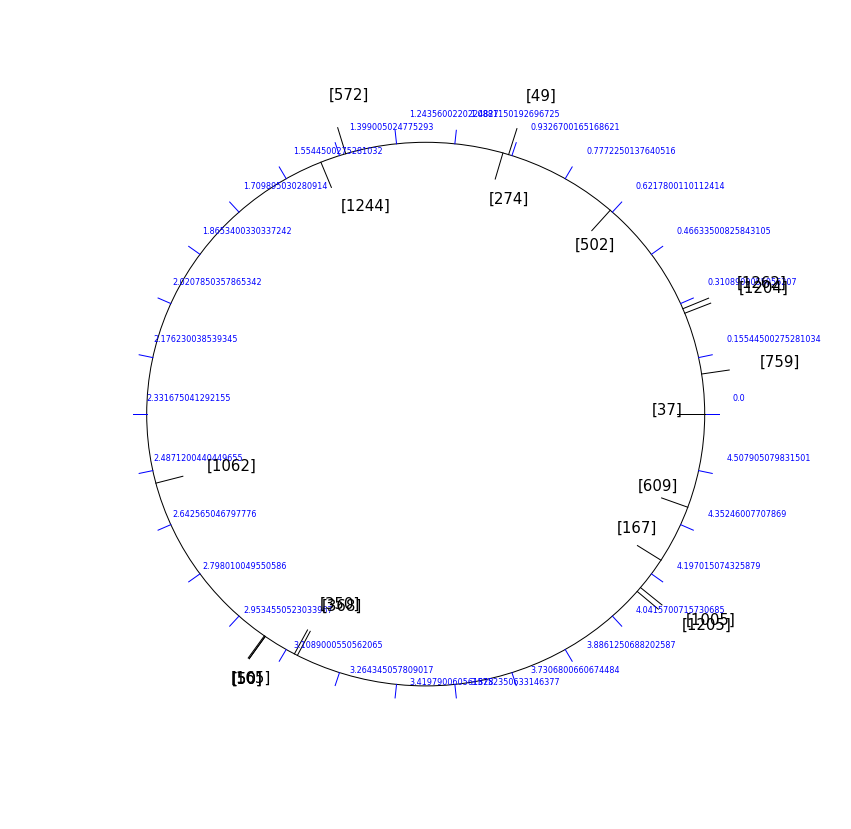

In [131]:
gamma = (1, 1, 1, 3, 3, 2)
visualizeShears(gamma, pantsDict, pantsInd)

In [123]:
print([(len(a), len(b), m,n,q,w) for (a,b,m,n,q,w) in getInequalityIndices2(posGeoList, pantsList, pantsInd, pantsDict, gamma)])

0.5294052119867049 0.7294052119867048 [759] [1005]
0.5294052119867049 1.0576419380268764 [759] [1005]
0.8576419380268764 1.0576419380268764 [759] [1005]
1.3516589240416796 1.5516589240416798 [49] [1262]
2.422349213795602 2.6223492137956024 [165] [572]
2.422349213795602 3.233829172280838 [165] [572]
2.422349213795602 3.2428071877497575 [165] [572]
3.033829172280838 3.233829172280838 [165] [572]
3.033829172280838 3.2428071877497575 [165] [572]
3.0428071877497573 3.233829172280838 [165] [572]
3.0428071877497573 3.2428071877497575 [165] [572]
4.14218469455338 4.342184694553379 [1205] [50]
4.14218469455338 4.503744082112846 [1205] [50]
4.14218469455338 0.09999998112871022 [1205] [50]
4.303744082112846 4.342184694553379 [1205] [50]
4.303744082112846 4.503744082112846 [1205] [50]
4.303744082112846 0.09999998112871022 [1205] [50]
4.563350063713021 0.09999998112871022 [1205] [50]
[(1, 0, [502], [502], 'empty', 'empty'), (2, 0, [502], [274], 'empty', 'empty'), (3, 3, [502], [1244], [759], [1262]